In [27]:
# Base on wandb documentation: Scikit-learn integration
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.exceptions import ConvergenceWarning
import warnings
import pickle
import wandb
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, roc_curve, mean_squared_error

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
# Failed to detect the name of this notebook...
os.environ['WANDB_NOTEBOOK_NAME'] = '06_opiod_wandb_tree.ipynb'

In [4]:
wandb.login()

wandb: Currently logged in as: idiazl (dev_ml_ops). Use `wandb login --relogin` to force relogin


True

In [5]:
data = 'CaseStudy_training_data.xlsx'
df = pd.read_excel(data, sheet_name='Model_data')

3. Data cleaning

In [6]:
df_cleaned = df.dropna()
df_cleaned = df_cleaned.drop_duplicates()
df_cleaned = df_cleaned.drop(['ID'], axis=1)
df_cleaned = df_cleaned.rename(columns={'rx ds': 'rx_ds'})

4. Feature Engineering

In [7]:
# Perform percentile-based bucketing for 'rx_ds'
df_features = df_cleaned.copy()
df_features['rx_ds_bucket'] = pd.qcut(
    df_cleaned['rx_ds'], 
    q=4, 
    labels=['Q1', 'Q2', 'Q3', 'Q4']
    )

In [8]:
# Create a new feature that is the sum of all the binary features
binary_cols = [col for col in df_features.columns if col not in ['OD', 'rx_ds', 'rx_ds_bucket']]
df_features['binary_sum'] = df_features[binary_cols].sum(axis=1)

# Create a new feature that is the ratio of 'rx_ds' to the sum of binary features
df_features['rx_ds_to_binary_sum'] = df_features['rx_ds'] / df_features['binary_sum']

In [9]:
# Perform one-hot encoding for 'rx_ds_bucket'
df_one_hot = pd.get_dummies(df_features['rx_ds_bucket'], prefix='rx_ds_bucket')
df_features = pd.concat([df_features, df_one_hot], axis=1)
df_features.drop(['rx_ds_bucket'], axis=1, inplace=True)

## Runs for model training

### 1. Classification - Decision Tree

In [10]:
from sklearn.model_selection import train_test_split

df_tree = df_features.copy()

X = df_tree.drop(['OD', 'rx_ds'], axis=1)
y = df_tree['OD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Defining a function to calculate the metrics for the classifier
def calculate_metrics(y_test, y_pred, model, X_test):
    metrics = {}
    metrics["accuracy"] = accuracy_score(y_test, y_pred)
    metrics["precision"] = precision_score(y_test, y_pred)
    metrics["recall"] = recall_score(y_test, y_pred)
    metrics["f1"] = f1_score(y_test, y_pred)
    metrics["roc_auc"] = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = conf_matrix.ravel()
    
    metrics["ppv"] = TP / (TP + FP)
    metrics["npv"] = TN / (TN + FN)
    metrics["specificity"] = TN / (TN + FP)
    
    return metrics

In [12]:
# Define a function to calculate tthe metrics speciffically for the tree model
def calculate_tree_metrics(model, X_test, y_test):
    tree_metrics = {}
    tree_metrics["tree_depth"] = model.get_depth()
    tree_metrics["num_leaves"] = model.get_n_leaves()
    ccp_path = model.cost_complexity_pruning_path(X_test, y_test)
    tree_metrics["ccp_alphas"] = ccp_path.ccp_alphas
    tree_metrics["impurities"] = ccp_path.impurities
    
    return tree_metrics

In [13]:
# New wandb project and run
run = wandb.init(project='wandb-sklearn-tree', name="classifier_decision_tree")

In [148]:
tree_hyperparams = {
    'criterion': 'entropy', # Measure for the quality of a split.
    'splitter': 'random', # best
    'max_depth': 50, 
    'min_samples_split': 10, # Minimum number of samples required to split an internal node.
    'min_samples_leaf': 4, # Minimum number of samples required to be at a leaf node.
    'max_features': None, # Maximum number of features considered for splitting a node.
    'max_leaf_nodes': 30, # Maximum number of leaf nodes in the tree.
    'min_impurity_decrease': 0.0, # Minimum impurity decrease required for a split to occur.
    'min_weight_fraction_leaf': 0.15, # Minimum weighted fraction of the sum total of weights required to be at a leaf node.
    'class_weight': 'balanced', # Weights associated with classes in the form {class_label: weight}.
    'ccp_alpha': 0.0, # Complexity parameter used for Minimal Cost-Complexity Pruning.
    'random_state': 42
}


wandb.config = tree_hyperparams

In [69]:
# Alterantevely
tree_hyperparams = {
    'criterion': 'entropy',
    'splitter': 'best',
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': None,
    'max_leaf_nodes': 10,
    'min_impurity_decrease': 0.0,
    'min_weight_fraction_leaf': 0.0,
    'class_weight': 'balanced',
    'ccp_alpha': 0.0,
    'random_state': 42
}
wandb.config = tree_hyperparams

In [149]:
# Initializing the model, Fitting and predicting
tree_model = DecisionTreeClassifier(**wandb.config)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

In [150]:
# Calculate the metrics
y_pred = tree_model.predict(X_test)
classification_metrics = calculate_metrics(y_test, y_pred, tree_model, X_test)
tree_metrics = calculate_tree_metrics(tree_model, X_test, y_test)

# Classification Metrics DataFrame
results_classification = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (PPV)', 'Recall (Sensitivity)', 'Specificity', 'F1 Score', 'Positive Predictive Value (PPV)', 'Negative Predictive Value (NPV)', 'ROC AUC'],
    'Value': [classification_metrics['accuracy'], classification_metrics['precision'], classification_metrics['recall'], classification_metrics['specificity'], classification_metrics['f1'], classification_metrics['ppv'], classification_metrics['npv'], classification_metrics['roc_auc']]
})

# Round numerical values to 2 decimal places
results_classification['Value'] = results_classification['Value'].round(2)

# Decision Tree Metrics DataFrame
results_tree = pd.DataFrame({
    'Metric': ['Tree Depth', 'Number of Leaves', 'CCP Alphas', 'Impurities'],
    'Value': [tree_metrics['tree_depth'], tree_metrics['num_leaves'], tree_metrics['ccp_alphas'], tree_metrics['impurities']]
})

# Convert arrays to string for better representation
results_tree.loc[results_tree['Metric'].isin(['CCP Alphas', 'Impurities']), 'Value'] = results_tree.loc[results_tree['Metric'].isin(['CCP Alphas', 'Impurities']), 'Value'].apply(str)


### Visualizations

In [151]:
results_classification

,Metric,Value
0,Accuracy,0.66
1,Precision (PPV),0.46
2,Recall (Sensitivity),0.86
3,Specificity,0.57
4,F1 Score,0.60
5,Positive Predictive Value (PPV),0.46
6,Negative Predictive Value (NPV),0.91
7,ROC AUC,0.77


In [152]:
results_tree

,Metric,Value
0,Tree Depth,2
1,Number of Leaves,3
2,CCP Alphas,[0. 0.00358534 0.01108882 0.04355267 0...
3,Impurities,[0.7861074 0.78969274 0.80078156 0.84433423 1...


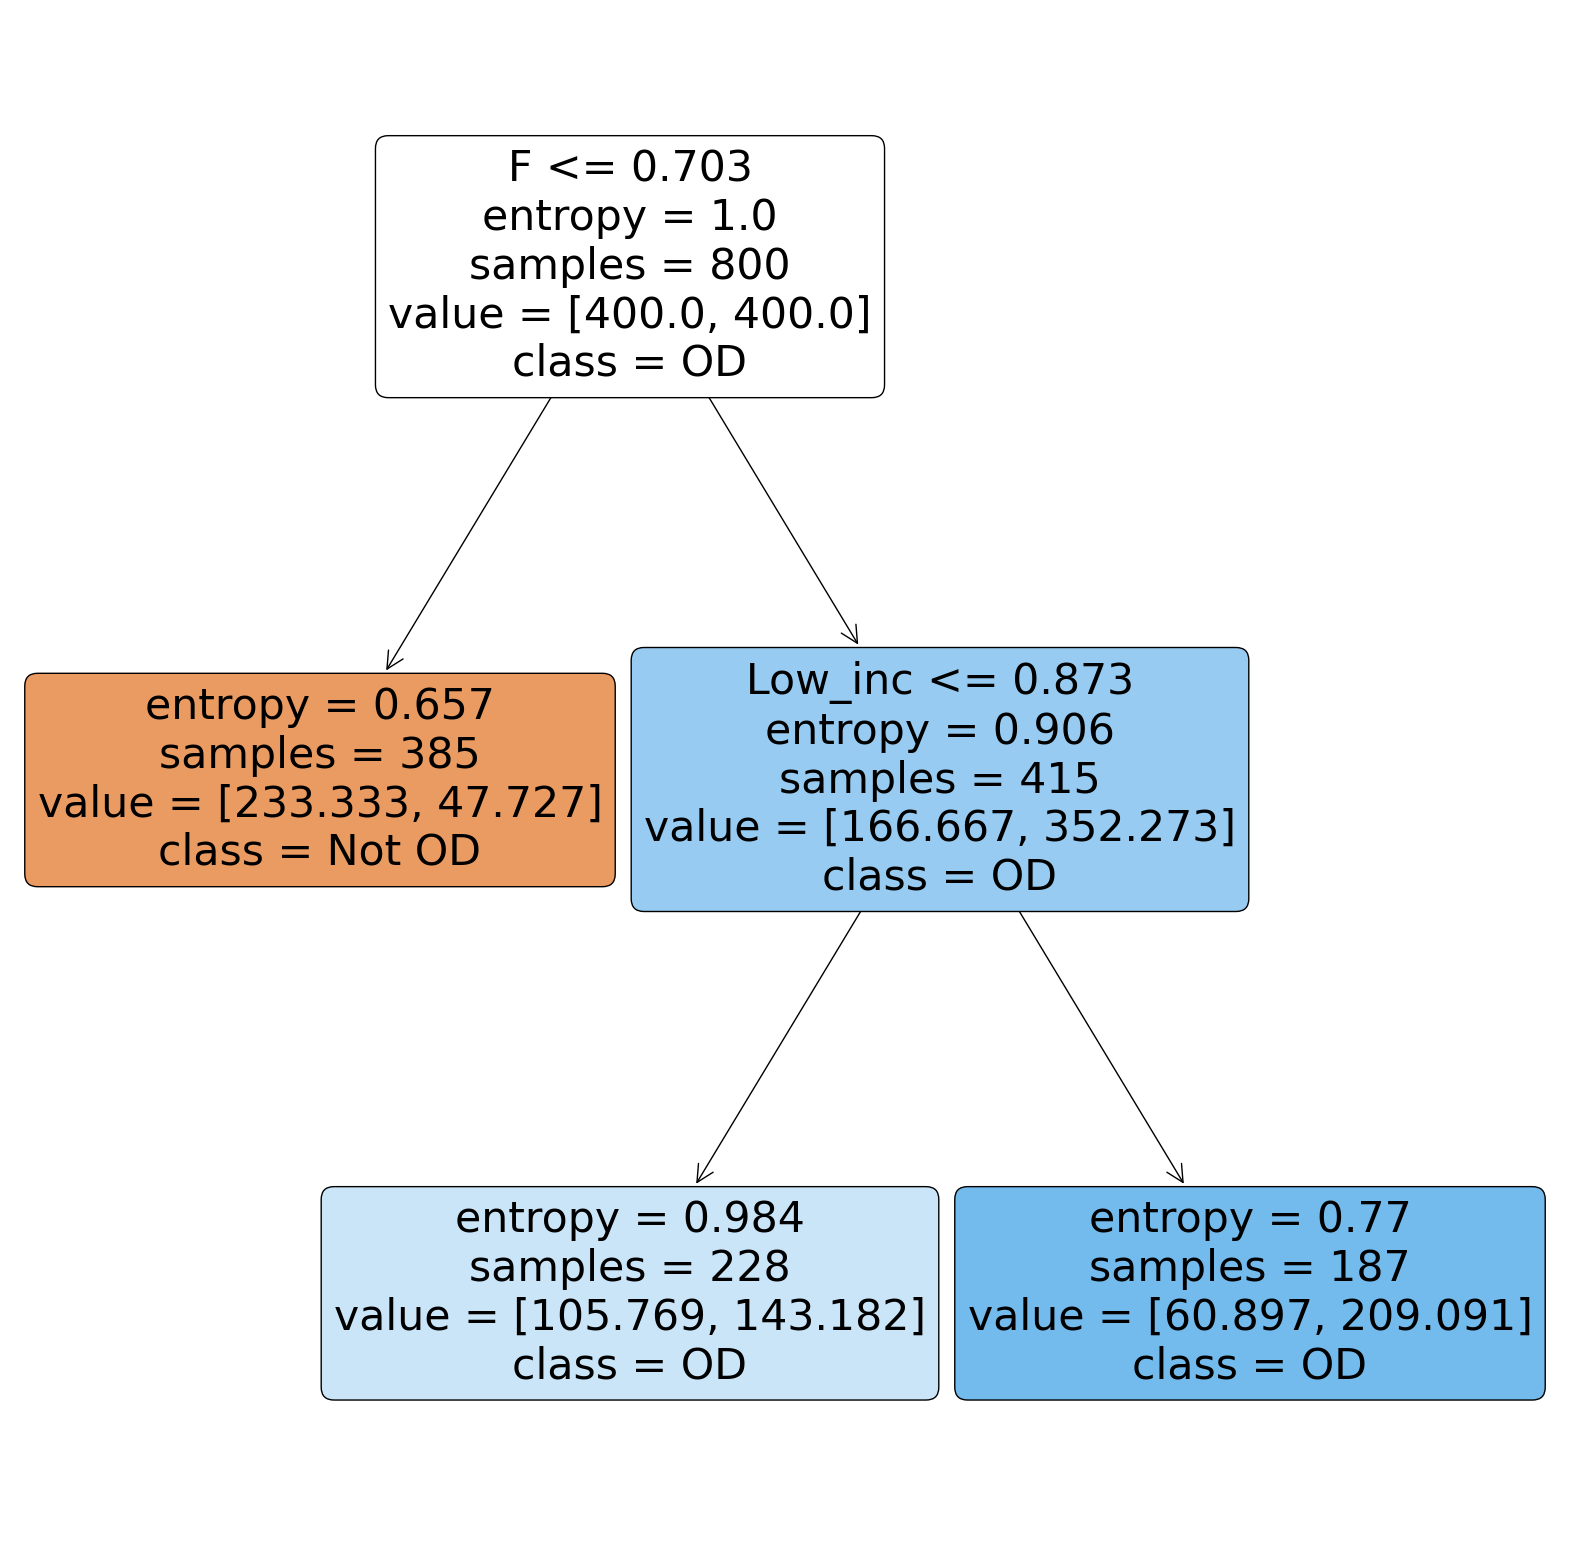

In [153]:
# Visualize the Decision Tree to nderstand the decision paths and criteria at each node
plt.figure(figsize=(20, 20))
plot_tree(tree_model, filled=True, rounded=True, class_names=["Not OD", "OD"], feature_names=X.columns)
plt.show()

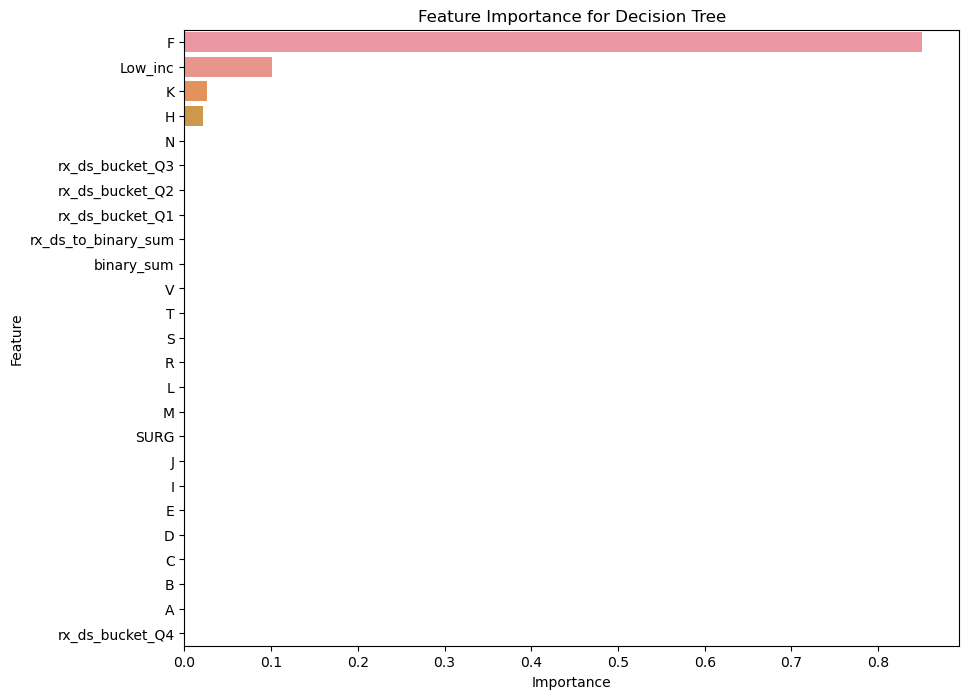

In [142]:
# Show Feature Importances
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': tree_model.feature_importances_}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Tree characteristics and metrics

In [143]:
# Extract the decision paths for specific samples
decision_paths = tree_model.decision_path(X_test)

decision_paths_array = decision_paths.toarray()

decision_paths_df = pd.DataFrame(decision_paths_array)
decision_paths_df.head()

,0,1,2,3,4,5,6,7,8
0,1,1,0,0,0,0,1,0,0
1,1,0,1,0,1,0,0,0,1
2,1,0,1,0,1,0,0,0,1
3,1,1,0,0,0,0,1,0,0
4,1,1,0,0,0,0,1,0,0


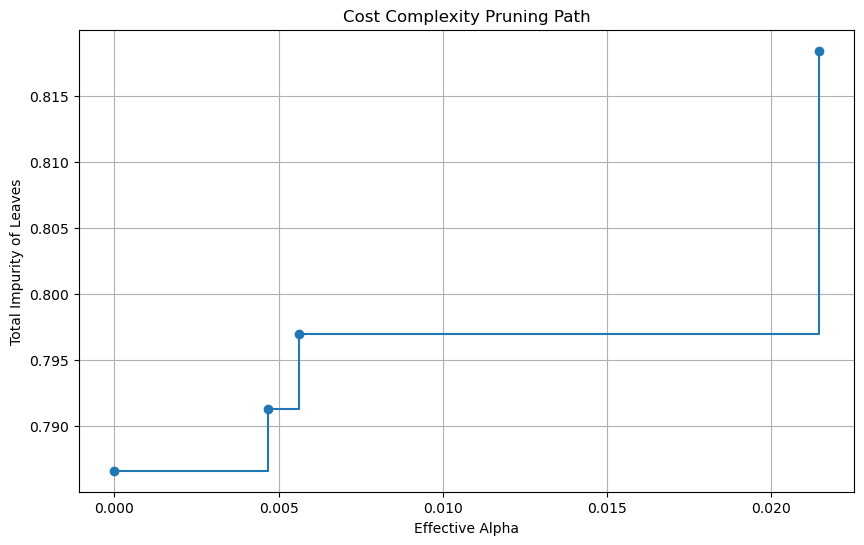

In [147]:
# Pruning to improve performance, and avoiding overfitting
ccp_path = tree_model.cost_complexity_pruning_path(X_train, y_train)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(ccp_path.ccp_alphas[:-1], ccp_path.impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("Effective Alpha")
plt.ylabel("Total Impurity of Leaves")
plt.title("Cost Complexity Pruning Path")
plt.grid(True)
plt.show()


### Logging metrics

In [23]:
# Logging the performance metrics
y_pred = tree_model.predict(X_test)
tree_metrics = calculate_metrics(y_test, y_pred, tree_model, X_test)

wandb.log(tree_metrics)

In [ ]:
# Logging the tree characteristics
tree_characteristics = calculate_tree_metrics(tree_model, X_test, y_test)

wandb.log(tree_characteristics)

#### Logging artifacts

In [24]:
# Save the model
os.makedirs('models', exist_ok=True)
with open("models/tree_model.pkl", "wb") as f:
    pickle.dump(tree_model, f)

# Log the model as a versioned file
artifact = wandb.Artifact("tree_model", type="model")
artifact.add_file("models/tree_model.pkl")
wandb.log_artifact(artifact)

<Artifact log_mode>

In [17]:
# Save the data
os.makedirs('data', exist_ok=True)
datasets = {"trainig": X, "validation": y}

for name, df in datasets.items():
    df.to_csv(f'data/{name}.csv', index=False)

# Log the `data` as an artifact
artifact = wandb.Artifact('train_val_sets', type='dataset', metadata={"Source": "CaseStudy_training_data.xlsx"})
artifact.add_dir('data')
wandb.log_artifact(artifact)

wandb: Adding directory to artifact (./data)... Done. 0.0s


<Artifact train_val_sets>

In [154]:
wandb.finish()